In [19]:
import numpy as np
import re
from datetime import datetime
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import matplotlib

Order of the Stick release data was copy directly from the OOTS wiki source (would have been easier than parsing the html). There were 7 sections in total. https://oots.fandom.com/wiki/List_of_Order_of_the_Stick_Comics

In [2]:
oots_data = open("oots_data.txt", "r", encoding="utf-8")
oots_string = oots_data.read()

In [3]:
oots_string[0:200]

'|-\n| [{{Comicpage|1}} 1]\n| [[New Edition]]\n| While fighting a bunch of Goblins, the Order is suddenly converted to Dungeons and Dragons 3.5 Edition.\n| 25 September 2003\n|-\n| [{{Comicpage|2}} 2]\n| [[Se'

To extract the dates (in the form "dd mmmm.. yyyy") we'll use regular expressions.

363, 364, 365, 222-227

222-227 were filled in manually based on existing schedules

In [4]:
dates = re.findall('\d+\s*\w+\s*\d{4}', oots_string)

In [5]:
datetime_list = [datetime.strptime(x, '%d %B %Y') for x in dates]

In [6]:
time_difference = []
for d in range(len(datetime_list) - 1):
    time_difference.append(datetime_list[d + 1] - datetime_list[d])

In [7]:
days_apart = [x.days for x in time_difference]

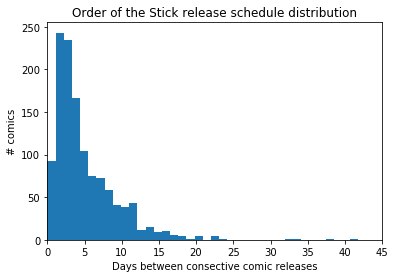

In [8]:
plt.hist(days_apart, bins = 100)
plt.xlabel("Days between consective comic releases")
plt.ylabel("# comics")
plt.xlim(0, 45)
plt.title("Order of the Stick release schedule distribution")
plt.show()

In [9]:
goblins_url = 'https://www.goblinscomic.com/comic/06252005' #first Goblins webcomic
titles = []
while True:
    request = requests.get(goblins_url)
    soup = BeautifulSoup(request.text,'html.parser')
    next_button = soup.find(class_ = 'cc-next')
    titles.append(soup.find('title'))
    if next_button == None:
        break
    goblins_url = next_button['href']

In [10]:
titles_str = [x.text for x in titles]
titles_str = [x[10:] for x in titles_str]

Below, I'm replacing inconsistent date formats. Likewise, our last comic will need to be 06/21/2017, because after then, the titles have nothing to do with the date published, and so unfortunately we can't use them. There's also a title called "Countdown Clocks and Dragon Slaying" situated between 07/06/2013 and 07/17/2013. To prevent it from looking like there was an 11-day break, I'll assume that Ellipsis (the author) published it on the 12th. 

In [11]:
titles_str = [x.replace('Title: 17042012', '04/17/2012') for x in titles_str]
titles_str = [x.replace('Countdown Clocks and Dragon Slaying', '07/12/2013') for x in titles_str]

In [12]:
trunc_dates = []
for i in titles_str:
    if i == 'Page 18':
        break
    else:
        trunc_dates.append(i)

In [13]:
goblins_datetime = [datetime.strptime(x, '%m/%d/%Y') for x in trunc_dates]

In [14]:
goblins_delta = []
for d in range(len(goblins_datetime) - 1):
    goblins_delta.append(goblins_datetime[d + 1] - goblins_datetime[d])

In [15]:
days_apart_goblins = [x.days for x in goblins_delta]

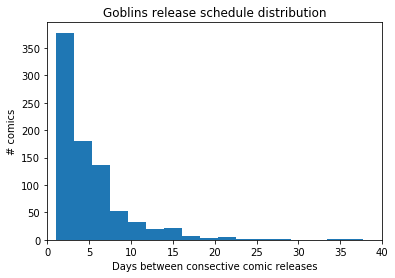

In [16]:
plt.hist(days_apart_goblins, bins = 100)
plt.xlabel("Days between consective comic releases")
plt.ylabel("# comics")
plt.xlim((0, 40))
plt.title("Goblins release schedule distribution")
plt.show()

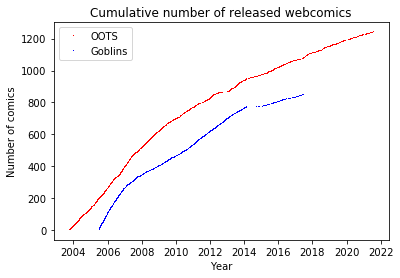

In [20]:
dates_oots = matplotlib.dates.date2num(datetime_list)
oots_plot = plt.plot_date(dates_oots, np.arange(0,len(datetime_list)), c = 'red', marker = ',', label = 'OOTS')
dates_goblin = matplotlib.dates.date2num(goblins_datetime)
goblin_plot = plt.plot_date(dates_goblin, np.arange(0,847), c = 'blue', marker = ',', label = 'Goblins')
plt.xlabel("Year")
plt.ylabel("Number of comics")
plt.title("Cumulative number of released webcomics")
plt.legend()
plt.show()

I would expect the release schedule distributions of the webcomics to follow an exponential distribution (this will be examined further in the R section). Looking at the release schedule distributions of OOTS and Goblins, they do appear to follow roughly exponential distributions. I believe the reason is because the underlying process of comic releasals is a Poisson point process. Poisson distributions describe the probability that some number of events will occur in a fixed time interval, given that these events occur with a constant average rate and are memoryless (independent of the time since the previous event). This ties into the exponential distribution because exponential distributions represent the time in-between Poisson processes. 

Webcomic releasals, at best, can only be roughly Poisson. It's unrealistic to expect that Rich Burlew/Ellipsis Stephens will have a constant average rate of comic book releasals. For example, you can already see that in September 2012, there is a break in the OOTS graph above, which corresponds to Rich Burlew breaking his thumb. After recovering, it appears that productivity went up for a short period of time (likely because he spent a lot of time thinking of plot content while injured, and the new bottleneck was his drawing speed). Likewise, in 2014, Ellipsis took a 6 month hiatus. 

$f(x, \lambda) = \lambda e^{-\lambda x}$ for $x \ge 0$

In [23]:
np.savetxt('goblins_days_apart.csv', days_apart_goblins, delimiter=',')
np.savetxt('oots_days_apart.csv', days_apart, delimiter=',')